# Risk Premia in REITs and its application in a quantitative value strategy

##### Dissertation for Master's degree in Economics from [Insper](https://www.insper.edu.br/en/graduate/masters-of-science/)

##### Advisor: [Prof. Dr. Gustavo B. Soares](https://github.com/gustavobsoares/) ([CV](http://lattes.cnpq.br/8491228979459078))
##### Student: Lucas L. Sanches ([Resume](http://lattes.cnpq.br/2528322802099316))

# Database Notebook

### Imports

In [1]:
from utils.dicts import *

In [2]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from statsmodels.regression.rolling import RollingOLS
from linearmodels import LinearFactorModelGMM
from tqdm import tqdm
import statsmodels.api as sm
import scipy.stats as stats
import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt
%matplotlib inline

### Reading data and organizing series

A database of more than 25 years of excess returns was used, starting in January 1994 and ending in August 2021. As some series have a shorter history of existence, the maximum available for some indices and specific assets was used. In addition to indices and assets related to the real estate market, series of equity and fixed income indices in the US and Brazil were also used. For easy replication of the results of this work, the data were retrieved from the Bloomberg database, through total return indices. For the historic series of factors, data from [Kenneth R. French](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) and from the [NEFIN](http://www.nefin.com.br/risk_factors.html) research center at USP were used. Finally, monthly returns were analyzed in all cases, for the sake of tradionalism in Finance.

In [3]:
data = pd.read_excel('data/data.xlsx', sheet_name='total_return', index_col=0)
BDAYS = pd.bdate_range(start=data.index[0], end=data.index[-1],
                       freq=pd.tseries.offsets.CustomBusinessDay(calendar=USFederalHolidayCalendar()))
data.index = pd.to_datetime(data.index)
data = data.loc[BDAYS]
monthly_data = np.log(data.resample('M').last()).diff().dropna()
print(data.columns)
data.tail()

Index(['BBREINDW Index', 'BBREDIVR Index', 'BBREPBST Index', 'BBREOUTL Index',
       'BBREHLTH Index', 'BBREAPT Index', 'BBREOFPY Index', 'BBRESHOP Index',
       'BBREHOTL Index', 'BBREMALL Index', 'BBREIT Index', 'SPXFP Index',
       'SPUSTTP Index', 'SPBDU1ST Index', 'IDUP LN Equity', 'D5BK B2 Equity',
       '1476 JT Equity', 'IBOV Index', 'IFIX Index', 'IBOV Index (ER)',
       'IFIX Index (ER)', 'BZAD10Y Index (acc)', 'BZDIOVRA Index (acc)',
       'BZAD10Y Index (ER)'],
      dtype='object')


,BBREINDW Index,BBREDIVR Index,BBREPBST Index,BBREOUTL Index,BBREHLTH Index,BBREAPT Index,BBREOFPY Index,BBRESHOP Index,BBREHOTL Index,BBREMALL Index,...,IDUP LN Equity,D5BK B2 Equity,1476 JT Equity,IBOV Index,IFIX Index,IBOV Index (ER),IFIX Index (ER),BZAD10Y Index (acc),BZDIOVRA Index (acc),BZAD10Y Index (ER)
2021-08-25,14.474287,8.536771,37.85282,14.08077,5.709986,20.62402,7.743902,5.390202,1.609628,7.360443,...,2.100561,1.299804,1.510694,324.8752,2.720346,0.573086,1.118500,2.735571,59.721780,1.001161
2021-08-26,14.515476,8.497911,38.04563,14.06784,5.661083,20.78372,7.700463,5.337423,1.583059,7.272520,...,2.096757,1.299804,1.524806,319.2453,2.722946,0.563042,1.119346,2.736666,59.733682,1.001362
2021-08-27,14.632325,8.651810,38.30584,14.20271,5.727037,20.91467,7.792159,5.456435,1.647087,7.427787,...,2.118314,1.299804,1.567142,324.4985,2.730604,0.572193,1.122270,2.737761,59.745587,1.001563
2021-08-30,14.898761,8.667509,38.71101,14.31039,5.753740,21.20611,7.756314,5.443757,1.626398,7.413056,...,2.118314,1.299804,1.582666,321.9773,2.740582,0.567408,1.125698,2.741046,59.781315,1.002166
2021-08-31,14.975773,8.697999,38.98682,14.38478,5.815512,21.29673,7.788858,5.462903,1.645345,7.472450,...,2.146212,1.299804,1.561498,319.3986,2.749230,0.562752,1.129025,2.742134,59.793230,1.002364


In [4]:
# Fama-French portfolios
ff_factors = (pd.read_excel('data/data.xlsx', sheet_name='fama_french_mom', index_col=0)/100)
ff_factors

,Mkt-RF,SMB,HML,RMW,CMA,Mom,RF
DATES,,,,,,,
199401,0.0287,-0.0001,0.0113,-0.0159,0.0145,0.0002,0.0025
199402,-0.0255,0.0266,-0.0159,0.0220,-0.0103,-0.0029,0.0021
199403,-0.0478,-0.0111,0.0163,0.0055,0.0127,-0.0133,0.0027
199404,0.0068,-0.0106,0.0166,0.0111,0.0112,0.0041,0.0027
199405,0.0058,-0.0252,0.0066,0.0066,0.0070,-0.0215,0.0031
...,...,...,...,...,...,...,...
202102,0.0278,0.0451,0.0708,0.0009,-0.0197,-0.0767,0.0000
202103,0.0308,-0.0097,0.0740,0.0643,0.0344,-0.0583,0.0000
202104,0.0493,-0.0306,-0.0074,0.0226,-0.0271,0.0101,0.0000


In [5]:
# Brazil Fama-French portfolios
bz_factors = (pd.read_excel('data/data.xlsx', sheet_name='nefin_ff_mom', index_col=0))
monthly_bz_factors = np.log(1+bz_factors).resample('M').sum()
monthly_bz_factors

,Mkt-RF,SMB,HML,Mom,RF
DATES,,,,,
2001-01-31,0.130624,0.029193,0.115051,-0.026903,0.011879
2001-02-28,-0.089178,0.011892,0.063005,0.084164,0.010082
2001-03-31,-0.080485,0.029296,0.029525,0.061151,0.013162
2001-04-30,0.026501,-0.075990,-0.112569,-0.051154,0.013018
2001-05-31,-0.003467,-0.016029,-0.144571,-0.020560,0.014141
...,...,...,...,...,...
2021-04-30,0.025022,0.113588,0.027758,0.068498,0.002340
2021-05-31,0.055394,0.015938,-0.001553,-0.029307,0.002923
2021-06-30,0.001569,0.064147,-0.011602,-0.002145,0.003307


In [6]:
# Additional data for miscellaneous experiments with international real estate ETFs
data_rates = pd.read_excel('data/data.xlsx', sheet_name='rates', index_col=0)
data_rates.index = pd.to_datetime(data_rates.index)
data_rates = data_rates.loc[BDAYS].dropna(how='all').fillna(method='ffill')
monthly_data_rates = np.log(1+data_rates[['US0003M Index','JY0003M Index','EUR003M Equity']].resample('M').last()/100)/12
data_rates

,USDBRL Curncy,USDJPY Curncy,USDEUR Curncy,US0003M Index,JY0003M Index,EUR003M Equity
1994-01-03,0.1205,112.70,NaN,NaN,2.1250,NaN
1994-01-04,0.1224,112.64,0.8892,3.3750,2.1250,NaN
1994-01-05,0.1243,113.06,0.8887,3.3750,2.1875,NaN
1994-01-06,0.1263,112.62,0.8887,3.3750,2.1250,NaN
1994-01-07,0.1283,111.91,0.8855,3.3125,2.1875,NaN
...,...,...,...,...,...,...
2021-08-25,5.2143,110.02,0.8495,0.1238,-0.0963,-0.550
2021-08-26,5.2572,110.09,0.8509,0.1208,-0.0963,-0.550
2021-08-27,5.2038,109.84,0.8477,0.1199,-0.0988,-0.550
2021-08-30,5.1851,109.92,0.8477,0.1199,-0.0988,-0.549


In [7]:
# Extracting excess returns for REITs, with 3-month Libor
for reit in list(REITS.values()):
    monthly_data[reit] -= monthly_data_rates['US0003M Index']

In [8]:
# Statistics of monthly data
placeholders = list(range(len(data.columns[:-10])))
summary_statistics = pd.DataFrame({'Obs': placeholders, 'Mean': placeholders, 'Std': placeholders,
                                   'Max': placeholders, 'Min': placeholders}, index=data.columns[:-10])

for c in list(data.columns)[:-10]:
    aux = monthly_data[c].loc[monthly_data.index>START_DATES[c]]
    obs_ = len(aux)
    mean_ = aux.mean()
    std_ = aux.std()
    max_ = aux.max()
    min_ = aux.min()
    summary_statistics.loc[c] = [obs_, mean_, std_, max_, min_]
summary_statistics   

,Obs,Mean,Std,Max,Min
BBREINDW Index,331,0.005897,0.090680,0.625346,-0.852771
BBREDIVR Index,331,0.004307,0.054767,0.291778,-0.340585
BBREPBST Index,331,0.008697,0.056055,0.192894,-0.252369
BBREOUTL Index,331,0.005637,0.069108,0.513155,-0.430269
BBREHLTH Index,331,0.003035,0.064347,0.239677,-0.406083
BBREAPT Index,331,0.007077,0.057660,0.201372,-0.316480
BBREOFPY Index,331,0.003889,0.061934,0.284584,-0.365589
BBRESHOP Index,331,0.002864,0.069684,0.322399,-0.517118
BBREHOTL Index,331,-0.000707,0.089964,0.512860,-0.481630
BBREMALL Index,331,0.003894,0.087279,0.450221,-0.778938


<AxesSubplot:>

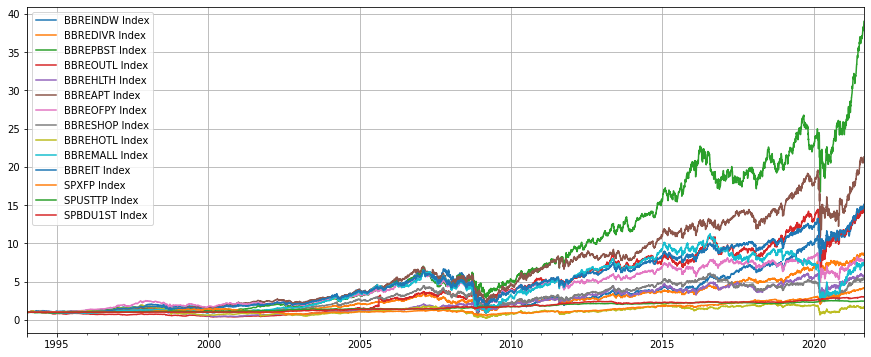

In [9]:
data[summary_statistics.index].plot(figsize=(15,6),grid=True)